In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1. Create Data set and Data loader

0 torch.Size([16, 1, 40, 40]) torch.Size([16])


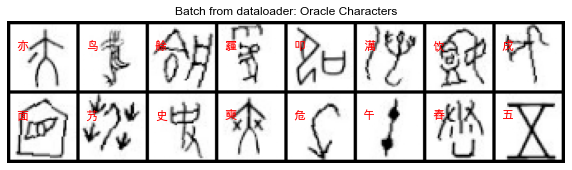

0 torch.Size([16, 1, 40, 40]) torch.Size([16])


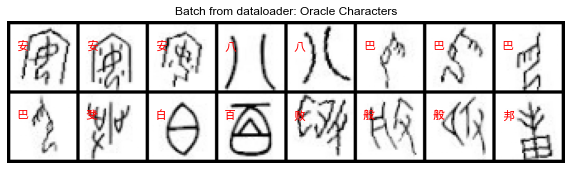

In [75]:

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

import os
import torch
import torchvision
# from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


from obs.make_dataset import create_dataloader, show_oracle_character


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

csv_file="../data/processed/image_name_label.csv"
root_dir='../data/raw/image/'


training_loader, dataset = create_dataloader(csv_file, root_dir, batch_size=16, rescale_size=45, randomcrop_size=40)

validation_loader, dataset = create_dataloader(csv_file, root_dir, batch_size=16, rescale_size=45, randomcrop_size=40, datatype='validation')

def show_loader_batch(dataloader):
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(),
            sample_batched['label'].size())
        plt.figure(figsize=(10,10))
        show_oracle_character(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        if i_batch == 0:
            break                      

show_loader_batch(training_loader)
show_loader_batch(validation_loader)


0 torch.Size([16, 1, 40, 40]) torch.Size([16])


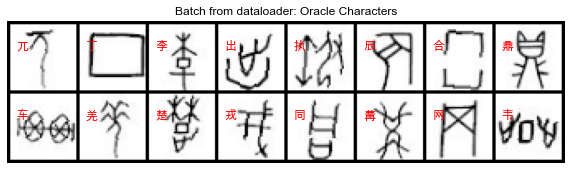

0 torch.Size([16, 1, 40, 40]) torch.Size([16])


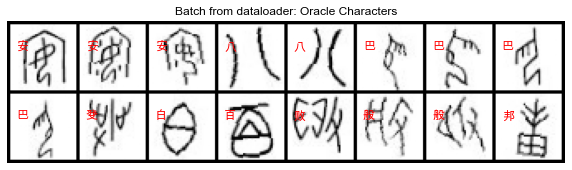

In [77]:
show_loader_batch(training_loader)
show_loader_batch(validation_loader)

## Classification Model

In [78]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

In [79]:
label2name_frame = pd.read_csv("../data/processed/label_name.csv")
class_number = len(label2name_frame)
print('Total class number is {}'.format(class_number))
label2name_frame

Total class number is 793


,label,name
0,0,子
1,1,合
2,2,酉
3,3,莫
4,4,朿
...,...,...
788,788,民
789,789,免
790,790,麋
791,791,尨


In [73]:
id2name = area_dict = dict(zip(label2name_frame.label, label2name_frame.name))
id2name

{0: '子',
 1: '合',
 2: '酉',
 3: '莫',
 4: '朿',
 5: '执',
 6: '戌',
 7: '戊',
 8: '丙',
 9: '辰',
 10: '疐',
 11: '老',
 12: '庚',
 13: '疋',
 14: '束',
 15: '卢',
 16: '毓',
 17: '壶',
 18: '商',
 19: '雨',
 20: '匜',
 21: '未',
 22: '鬲',
 23: '韦',
 24: '保',
 25: '中',
 26: '梦',
 27: '史',
 28: '咙',
 29: '车',
 30: '眢',
 31: '丁',
 32: '疾',
 33: '帚',
 34: '耤',
 35: '危',
 36: '齿',
 37: '示',
 38: '奭',
 39: '丰',
 40: '亥',
 41: '寅',
 42: '羌',
 43: '宜',
 44: '橐',
 45: '风',
 46: '龠',
 47: '丘',
 48: '巳',
 49: '并',
 50: '鸟',
 51: '祝',
 52: '西',
 53: '贮',
 54: '永',
 55: '襄',
 56: '戚',
 57: '袁',
 58: '黹',
 59: '我',
 60: '雇',
 61: '毌',
 62: '萑',
 63: '典',
 64: '泉',
 65: '封',
 66: '龟',
 67: '者',
 68: '贞',
 69: '午',
 70: '美',
 71: '乃',
 72: '寻',
 73: '舞',
 74: '郁',
 75: '焚',
 76: '奚',
 77: '方',
 78: '戠',
 79: '鸡',
 80: '辛',
 81: '晶',
 82: '宿',
 83: '呈',
 84: '王',
 85: '黍',
 86: '朝',
 87: '饮',
 88: '雝',
 89: '壴',
 90: '九',
 91: '爵',
 92: '矢',
 93: '六',
 94: '仓',
 95: '亳',
 96: '首',
 97: '土',
 98: '洀',
 99: '雷',
 100: '良',

In [80]:
# defining the model architecture
class Net(nn.Module):   
  def __init__(self, class_number):
      super(Net, self).__init__()
      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2), # a. half-of-size
          
          # Defining another 2D convolution layer
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2), # a. half-of-size
      )
      self.linear_layers = nn.Sequential(
          nn.Linear(64 * 5 * 5, class_number), # 793 
        #   nn.Linear(800, class_number) #  
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

# defining the model
model = Net(class_number)
  

In [81]:
# defining the loss function
loss_fn = nn.CrossEntropyLoss()
# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
# print(model_mlp)    

In [82]:
# The Training Loop
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair         
        inputs  = data['image'].float() 
        labels = data['label'].long()
        # inputs = Variable(inputs) 
      
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # 1602/16 = 100 reports on the loss for every 25 batches.
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            tb_writer.add_images('mage_batch', inputs, epoch_index) 

    return last_loss

In [83]:
# Per-Epoch Activity
# num_epochs = 20
# for epoch in range(num_epochs):
#     for data in dataloader:
#         img  = data['image'].float() 
#         label = data['label'].long()
#         img = Variable(img) 
#         output = model(img) 
#         loss = criterion(output, label)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     if epoch % 10 == 9:
#         print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))  
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/obs_{}'.format(timestamp))
epoch_number = 0
EPOCHS = 200

best_vloss = 10.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)
    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs  = vdata['image'].float() 
        vlabels = vdata['label'].long()
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)


                
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        model_path = 'model_best' 
        torch.save(model.state_dict(), model_path)
        writer.add_graph(model, vinputs)
        
    writer.flush()    
    epoch_number += 1


EPOCH 1:
  batch 100 loss: 11.291522059440613
LOSS train 11.291522059440613 valid 6.223927021026611
EPOCH 2:
  batch 100 loss: 5.799498138427734
LOSS train 5.799498138427734 valid 4.971818923950195
EPOCH 3:
  batch 100 loss: 4.798140587806702
LOSS train 4.798140587806702 valid 3.999103307723999
EPOCH 4:
  batch 100 loss: 3.6314882588386537
LOSS train 3.6314882588386537 valid 3.469926595687866
EPOCH 5:
  batch 100 loss: 2.6898333644866943
LOSS train 2.6898333644866943 valid 7.497805595397949
EPOCH 6:
  batch 100 loss: 2.064735361337662
LOSS train 2.064735361337662 valid 1.4677373170852661
EPOCH 7:
  batch 100 loss: 1.5273249620199203
LOSS train 1.5273249620199203 valid 1.6771268844604492
EPOCH 8:
  batch 100 loss: 1.1593198138475418
LOSS train 1.1593198138475418 valid 0.9708796739578247
EPOCH 9:
  batch 100 loss: 1.0041271962225438
LOSS train 1.0041271962225438 valid 0.8382788300514221
EPOCH 10:
  batch 100 loss: 0.9816614933311939
LOSS train 0.9816614933311939 valid 1.5554109811782837


In [54]:
PATH = 'model_best'
saved_model = Net(class_number)
saved_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Test Model

In [55]:
model

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1600, out_features=793, bias=True)
  )
)

In [56]:
correct_count, all_count = 0, 0
for data in validation_loader:
    images = data['image'].float()
    labels = data['label'].long()
    for i in range(len(labels)):
        # img = images[i].view(1, 1, 28, 28)
        img = images[i,:,:,:]
        img = torch.unsqueeze(img, dim=0)
        with torch.no_grad():
            logps = model(img)
        # ps = torch.exp(logps)
        # probab = list(ps.cpu()[0])
        pred_label = logps.argmax(1).item()
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images = 1602

Model Accuracy = 0.9444444444444444


In [57]:
sample = next(iter( validation_loader))
image = sample['image'].float()
label = sample['label']
name = sample['name']

model.eval()
pred = model(image)
pred_label = pred.argmax(dim=1)
print("\nPredicted Label =", pred_label)
print("\nTrue Label =", label)


Predicted Label = tensor([151, 151, 151, 237, 237, 107, 107, 107, 107, 620, 619, 618, 617, 329,
        329, 616])

True Label = tensor([151, 151, 151, 237, 237, 107, 107, 107, 107, 620, 619, 618, 617, 329,
        329, 616])


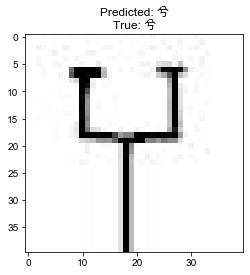

In [66]:
id = np.random.randint(0, len(dataset))
# print(id)
sample = dataset[id] 
image = sample['image']
label = sample['label']
name = sample['name']
image.shape, label, name 
model.eval()
pred = model(image.unsqueeze(0).float())
pred_label = pred.argmax(dim=1).item()
# pred.shape, 
# print(pred.shape)
# print(pred.argmax(dim=1))
# pred_label, label.item(), name
title = 'Predicted: {}\nTrue: {}'.format(id2name[pred_label], id2name[label.item()])
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(title)
plt.show()

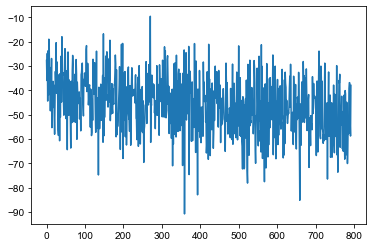

In [67]:
plt.plot(pred.detach().squeeze().numpy())

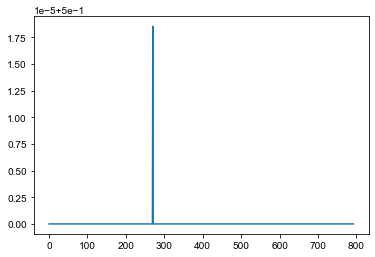

In [68]:
ps = torch.exp(pred)
prob_dist = torch.sigmoid(ps).detach().numpy()[0]
# prob_dist = torch.nn.Softmax(ps).detach().numpy()[0]
plt.plot(prob_dist)

In [61]:
# prob_dist = torch.special.expit(pred).detach().numpy()[0]
# plt.plot(prob_dist)

In [62]:
# prob_dist = pred.detach().numpy().squeeze()
# prob_dist.shape

# fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# axs[0].plot( prob_dist)
# axs[1].plot(np.exp(prob_dist))

# print(np.argmax(prob_dist))
# print(np.argmax(np.exp(prob_dist)))